# Stone -  Estudo de dados - Churn

1. Uma métrica importante para acompanhamento na indústria de meios de
pagamento é o churn da base de clientes. 

* Tipicamente, a taxa de churn é
calculada: 
  * Razão entre a quantidade de clientes sem transacionar em um
determinado mês (mas ativos no mês anterior) e a quantidade total de clientes
que estavam ativos (i.e. transacionando) no mês anterior. 

* Considerando a definição de churn acima, crie uma variável indicadora churn para identificar se o
cliente está ativo ( churn = 0 ) ou deu churn ( churn = 1 ) em cada datee:
  1. crie um plot com a evolução da taxa de churn da companhia e por tier ao longo do tempo.
  2. Quais insights você destacaria para as lideranças da companhia?


In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot histagrans
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import plotly.graph_objects as go
import plotly.subplots as sp
import seaborn as sns
import plotly.express as px

# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
pd.options.display.float_format = "{:.2f}".format

## Base Clients

In [4]:
clients_df = "./data/Estudo de dados/Clients.csv"
clients_df = pd.read_csv(clients_df)

clients_df = clients_df.dropna(subset=["segment"])
clients_df.shape

(19952, 4)

### Métrica de total de tempo de cadastro na base

In [6]:
clients_df["created_at"] = pd.to_datetime(clients_df["created_at"])

# tempo de cadastro em meses
clients_df["idade"] = (
    (clients_df["created_at"].max() - clients_df["created_at"]).dt.days
) // 30

clients_df_2 = clients_df[["client", "segment", "idade"]]
clients_df_2

,client,segment,idade
0,1,N,2
1,2,B,16
2,3,B,17
3,4,I,41
4,5,F,50
...,...,...,...
19995,19996,N,47
19996,19997,N,18
19997,19998,B,39
19998,19999,B,14


## Tabela transactions

In [7]:
transactions_df_original = "./data/Estudo de dados/Transactions.csv"
transactions_df_original = pd.read_csv(transactions_df_original)

transactions_df_original["date"] = pd.to_datetime(
    transactions_df_original["date"]
).dt.date

transactions_df_original = transactions_df_original.sort_values(by=["date", "client"])
transactions_df_original.shape

(187230, 4)

In [8]:
### Combinar com informações de clientes
transactions_df_original = pd.merge(
    transactions_df_original, clients_df_2, on="client", how="inner"
)

total_clientes = transactions_df_original["client"].nunique()
print("Total de clientes:", total_clientes)
transactions_df_original.shape

Total de clientes: 19952


(186716, 6)

### Avaliar possiveis problemas na base de dados

In [442]:
transactions_df_original.describe()

,client,sales_volume,sales_count,idade
count,186716.00,186716.00,186716.00,186716.00
mean,9662.47,10484.76,157.29,26.01
std,5606.71,32593.71,472.45,14.93
min,1.00,-151381.32,0.00,0.00
25%,4989.75,1125.00,6.00,15.00
50%,9446.50,3913.97,33.00,23.00
75%,14231.00,10242.56,138.00,35.00
max,20000.00,4185543.61,37524.00,101.00


* As estatísticas descritivas mostram discrepâncias relevantes em sales_volume e sales_count, o que indica a necessidade de ajustes seja por regras de negócio ou remoção de outliers.
  * Variância muito grande gera viés tanto para clusterização qunato para churn.

### Ajustes necesários

* verificar missing
* Sales_volume negativo -> Erro, estorno?
* 0 < Sales_volume < 1.40 -> cusgto mensal maquina TOM  Ton Super: 12x de R$ 1,40;
* sales_count = 0 -> como tem registro se nada foi vendido?
* Outliers (super clientes): media + 2 std = 80k;
* Excluir clientes cadastrados no último mês.

#### Excluir clientes cadastrados no último mês (idade = 0)

Esses não tem métrica de churn 

In [12]:
transactions_df = transactions_df_original.copy()
transactions_df = transactions_df[transactions_df["idade"] > 0]

total_clientes = transactions_df["client"].nunique()
print("Total de clientes:", total_clientes)

Total de clientes: 19679


#### Excluir transacoes com contagem = 0

In [14]:
transactions_df = transactions_df[transactions_df["sales_count"] > 0]
total_clientes = transactions_df["client"].nunique()
print("Total de clientes:", total_clientes)

Total de clientes: 19671


#### Excluir receitas negativas

In [15]:
transactions_df = transactions_df.query("sales_volume > 0")
transactions_df.describe()

,client,sales_volume,sales_count,idade
count,185728.00,185728.00,185728.00,185728.00
mean,9657.70,10529.85,157.85,26.08
std,5604.06,32633.47,469.52,14.91
min,1.00,0.01,1.00,1.00
25%,4990.00,1148.87,7.00,15.00
50%,9438.00,3944.98,34.00,23.00
75%,14222.00,10287.99,139.00,35.00
max,20000.00,4185543.61,37524.00,101.00


## Churn

In [16]:
transactions_df.sort_values(by=["date"], inplace=True)

churn_df = transactions_df[["client", "segment", "date", "sales_volume"]]

Nesse exercício, eu nao preciso me preocupar em clusterizar e nem tratar dados outliers. Ambas tarefas foram avaliads no primeiro exercício de estudo de dados.

#### Trazer a informação de cluster por cliente

In [17]:
### Trazer a informação de chr por cliente
tier_df = pd.read_parquet("df_quintil_cluster.parquet")
tier_df = tier_df[["client", "tier"]]

churn_df = churn_df.merge(tier_df, on="client", how="inner")
churn_df

,client,segment,date,sales_volume,tier
0,4,I,2021-01-01,10167.17,9K-71K
1,4,I,2021-02-01,9920.42,9K-71K
2,4,I,2021-03-01,7696.05,9K-71K
3,4,I,2021-04-01,9584.33,9K-71K
4,4,I,2021-05-01,12637.89,9K-71K
...,...,...,...,...,...
185723,17961,K,2022-12-01,3425.55,2K-4K
185724,6140,I,2022-12-01,10.00,1.50-500
185725,19378,I,2022-12-01,1552.50,500-2K
185726,12951,M,2022-12-01,75.00,1.50-500


#### Estatísticas descritivas por tier:

Será utilizado para melhor separar o gráfico de churn por tier

In [18]:
stats_segment = (
    churn_df.groupby(["tier"], as_index=True, sort=True)
    .agg(
        {
            "client": ["nunique", "size"],
            "sales_volume": ["mean"],
        }
    )
    .round(2)
)

stats_segment.columns = stats_segment.columns.droplevel(1)

stats_segment.columns = [
    "#_clients",
    "#_registros",
    "sales_volume_avg",
]


stats_segment["clients_share"] = (
    stats_segment["#_clients"] / (stats_segment["#_clients"].sum()) * 100
)
stats_segment = stats_segment.sort_values(by="sales_volume_avg", ascending=False)

stats_segment

,#_clients,#_registros,sales_volume_avg,clients_share
tier,,,,
71K-2M,230,3178,145913.17,1.18
9K-71K,3875,52011,20679.81,19.93
4K-9K,3652,44734,6050.85,18.78
2K-4K,3705,40223,2736.57,19.05
500-2K,3758,30471,1064.45,19.33
1.50-500,3939,14769,217.47,20.26
0-1.5,285,342,0.67,1.47


 ###  Taxa de churn:
 * Razão entre a quantidade de clientes sem transacionar em um
determinado mês (mas ativos no mês anterior) e a quantidade total de clientes
que estavam ativos (i.e. transacionando) no mês anterior.

#### Passo 1: Identificar clientes ativos

In [19]:
churn_df["ativo"] = 1

In [21]:
# Usar client 125 para debug
churn_df.query("client ==125")

,client,segment,date,sales_volume,tier,ativo
154135,125,L,2021-11-01,303304.38,71K-2M,1
154136,125,L,2021-12-01,1047740.50,71K-2M,1
154137,125,L,2022-01-01,929190.06,71K-2M,1
154138,125,L,2022-02-01,865944.60,71K-2M,1
154139,125,L,2022-03-01,687414.48,71K-2M,1
154140,125,L,2022-05-01,561118.74,71K-2M,1
154141,125,L,2022-06-01,791069.24,71K-2M,1
154142,125,L,2022-07-01,545790.05,71K-2M,1
154143,125,L,2022-08-01,205.00,71K-2M,1


#### Passo 2: Identificar mês subsequente sem compra 

1. Expandir a base para todas as datas disponíveis por cliente:

In [ ]:
churn_df["date"] = pd.to_datetime(churn_df["date"])

# Identificar todos os clientes:
all_clients = churn_df["client"].unique()

# Criar range de data
all_dates = pd.date_range(
    churn_df["date"].min(), churn_df["date"].max(), freq="MS"
)  # Monthly start

# Expandir a série
expanded_index = pd.MultiIndex.from_product(
    [all_clients, all_dates], names=["client", "date"]
)
expanded_df = pd.DataFrame(index=expanded_index).reset_index()

2. Trazer informações da base transactions_df

In [24]:
expanded_df = expanded_df.merge(churn_df, on=["client", "date"], how="left")
expanded_df.sort_values(by=["client", "date"], inplace=True)
expanded_df

,client,date,segment,sales_volume,tier,ativo
453912,1,2021-01-01,NaN,NaN,NaN,NaN
453913,1,2021-02-01,NaN,NaN,NaN,NaN
453914,1,2021-03-01,NaN,NaN,NaN,NaN
453915,1,2021-04-01,NaN,NaN,NaN,NaN
453916,1,2021-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
331675,20000,2022-08-01,M,12558.25,9K-71K,1.00
331676,20000,2022-09-01,M,9963.50,9K-71K,1.00
331677,20000,2022-10-01,M,9080.00,9K-71K,1.00
331678,20000,2022-11-01,M,9025.00,9K-71K,1.00



Atenção: Existem situações em que cliente para de realizar transações no mês subsequente, porém, retorna a utilizar o erviço no outro mês.

3. Identificar mês subsequente como inativo

In [25]:
# Preencher NaN ativo = 0
expanded_df["ativo"] = expanded_df["ativo"].fillna(0)

# Para manter aitov =0 entre meses como receita
expanded_df.update(expanded_df.groupby("client").ffill())

,client,date,segment,sales_volume,tier,ativo
453912,1,2021-01-01,NaN,NaN,NaN,0.00
453913,1,2021-02-01,NaN,NaN,NaN,0.00
453914,1,2021-03-01,NaN,NaN,NaN,0.00
453915,1,2021-04-01,NaN,NaN,NaN,0.00
453916,1,2021-05-01,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...
331675,20000,2022-08-01,M,12558.25,9K-71K,1.00
331676,20000,2022-09-01,M,9963.50,9K-71K,1.00
331677,20000,2022-10-01,M,9080.00,9K-71K,1.00
331678,20000,2022-11-01,M,9025.00,9K-71K,1.00


In [26]:
# Debug
expanded_df.query("client ==125")

,client,date,segment,sales_volume,tier,ativo
321336,125,2021-01-01,NaN,NaN,NaN,0.00
321337,125,2021-02-01,NaN,NaN,NaN,0.00
321338,125,2021-03-01,NaN,NaN,NaN,0.00
321339,125,2021-04-01,NaN,NaN,NaN,0.00
321340,125,2021-05-01,NaN,NaN,NaN,0.00
321341,125,2021-06-01,NaN,NaN,NaN,0.00
321342,125,2021-07-01,NaN,NaN,NaN,0.00
321343,125,2021-08-01,NaN,NaN,NaN,0.00
321344,125,2021-09-01,NaN,NaN,NaN,0.00
321345,125,2021-10-01,NaN,NaN,NaN,0.00


#### Passo 3: Excluir meses desnecessários

##### Antes do primeiro registro

In [27]:
expanded_df = expanded_df.dropna(subset=["sales_volume"])

##### Após o último registro

In [28]:
expanded_df["combined"] = (
    expanded_df["client"].astype(str)
    + "_"
    + expanded_df["sales_volume"].astype(str)
    + "_"
    + expanded_df["ativo"].astype(str)
)

expanded_df.query("client==125")

,client,date,segment,sales_volume,tier,ativo,combined
321346,125,2021-11-01,L,303304.38,71K-2M,1.00,125_303304.38_1.0
321347,125,2021-12-01,L,1047740.50,71K-2M,1.00,125_1047740.5_1.0
321348,125,2022-01-01,L,929190.06,71K-2M,1.00,125_929190.06_1.0
321349,125,2022-02-01,L,865944.60,71K-2M,1.00,125_865944.6_1.0
321350,125,2022-03-01,L,687414.48,71K-2M,1.00,125_687414.48_1.0
321351,125,2022-04-01,L,687414.48,71K-2M,0.00,125_687414.48_0.0
321352,125,2022-05-01,L,561118.74,71K-2M,1.00,125_561118.74_1.0
321353,125,2022-06-01,L,791069.24,71K-2M,1.00,125_791069.24_1.0
321354,125,2022-07-01,L,545790.05,71K-2M,1.00,125_545790.05_1.0
321355,125,2022-08-01,L,205.00,71K-2M,1.00,125_205.0_1.0


In [29]:
expanded_df = expanded_df[~expanded_df["combined"].duplicated(keep="first")]

In [30]:
expanded_df.query("client==125")

,client,date,segment,sales_volume,tier,ativo,combined
321346,125,2021-11-01,L,303304.38,71K-2M,1.00,125_303304.38_1.0
321347,125,2021-12-01,L,1047740.50,71K-2M,1.00,125_1047740.5_1.0
321348,125,2022-01-01,L,929190.06,71K-2M,1.00,125_929190.06_1.0
321349,125,2022-02-01,L,865944.60,71K-2M,1.00,125_865944.6_1.0
321350,125,2022-03-01,L,687414.48,71K-2M,1.00,125_687414.48_1.0
321351,125,2022-04-01,L,687414.48,71K-2M,0.00,125_687414.48_0.0
321352,125,2022-05-01,L,561118.74,71K-2M,1.00,125_561118.74_1.0
321353,125,2022-06-01,L,791069.24,71K-2M,1.00,125_791069.24_1.0
321354,125,2022-07-01,L,545790.05,71K-2M,1.00,125_545790.05_1.0
321355,125,2022-08-01,L,205.00,71K-2M,1.00,125_205.0_1.0


### Tabela final da cálculos de churn

In [31]:
churn_df_2 = expanded_df.drop(columns=["sales_volume", "combined"])
churn_df_2.query("client==125")

,client,date,segment,tier,ativo
321346,125,2021-11-01,L,71K-2M,1.00
321347,125,2021-12-01,L,71K-2M,1.00
321348,125,2022-01-01,L,71K-2M,1.00
321349,125,2022-02-01,L,71K-2M,1.00
321350,125,2022-03-01,L,71K-2M,1.00
321351,125,2022-04-01,L,71K-2M,0.00
321352,125,2022-05-01,L,71K-2M,1.00
321353,125,2022-06-01,L,71K-2M,1.00
321354,125,2022-07-01,L,71K-2M,1.00
321355,125,2022-08-01,L,71K-2M,1.00


## Taxa de churn - Visão geral - Sem ponderação

In [32]:
def compute_churn_rate_overall(df):
    # Step 1: Group by date and ativo status, then count clients
    churn_stats = (
        df.groupby(["date", "ativo"])["client"]
        .nunique()  # Count unique clients per date per ativo status
        .reset_index()
        .pivot(index="date", columns="ativo", values="client")
    )

    churn_stats.columns = [
        "inativo_t",
        "ativo_t",
    ]

    # Step 2: Compute Previous Active Clients (shift ativo_t)
    churn_stats["prev_ativo"] = churn_stats["ativo_t"].shift(1)

    # Step 3: Compute Churn Rate (Avoid division by zero)
    churn_stats["churn_rate"] = (
        churn_stats["inativo_t"] / churn_stats["prev_ativo"]
    ) * 100

    # Step 4: Drop columns churn_rate is NaN
    churn_stats.dropna(subset="churn_rate", inplace=True)

    return churn_stats.reset_index()


churn_df_overall = compute_churn_rate_overall(churn_df_2)
churn_df_overall

,date,inativo_t,ativo_t,prev_ativo,churn_rate
0,2021-02-01,608.00,6253.00,6150.00,9.89
1,2021-03-01,700.00,6348.00,6253.00,11.19
2,2021-04-01,679.00,6484.00,6348.00,10.70
3,2021-05-01,650.00,6675.00,6484.00,10.02
4,2021-06-01,666.00,6865.00,6675.00,9.98
5,2021-07-01,627.00,7298.00,6865.00,9.13
6,2021-08-01,769.00,7613.00,7298.00,10.54
7,2021-09-01,698.00,7958.00,7613.00,9.17
8,2021-10-01,721.00,8359.00,7958.00,9.06
9,2021-11-01,746.00,8672.00,8359.00,8.92


##### Gráfico Tendência Vs Volume - Visão geral

In [33]:
def plot_churn_analysis(df, line_feature, bar_feature):
    churn_df = df.copy()
    churn_df_mean = churn_df[line_feature].mean().round(2)

    # Create subplots with 2 rows and shared x-axis
    fig = sp.make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        subplot_titles=("Churn Rate Over Time", "Inactive Clients Over Time"),
        vertical_spacing=0.2,
    )

    # Custom hover template for both charts to show in one hover popup
    hover_template = (
        "<b>Date:</b> %{x}<br>"
        + "<b>Churn Rate:</b> %{y:.2f}%<br>"
        + "<b>Inactive Clients:</b> %{customdata}"
    )

    # Top chart: Churn Rate (Line plot)
    fig.add_trace(
        go.Scatter(
            x=churn_df["date"],
            y=churn_df[line_feature],
            mode="lines+markers",
            name="Churn Rate",
            line=dict(color="red"),
            customdata=churn_df[bar_feature],  # Pass inactive clients to hover
            hovertemplate=hover_template,  # Custom hover tooltip
        ),
        row=1,
        col=1,
    )

    # Bottom chart: Inactive Clients (Bar plot)
    fig.add_trace(
        go.Bar(
            x=churn_df["date"],
            y=churn_df[bar_feature],
            name="Inactive Clients",
            marker_color="blue",
            customdata=churn_df[line_feature],  # Pass churn rate to hover
            hovertemplate=hover_template,  # Custom hover tooltip
        ),
        row=2,
        col=1,
    )

    # Update layout to enable hover for both charts
    fig.update_layout(
        height=600,
        width=900,
        hovermode="x unified",  # Enables synchronized hover
        legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1.04),
        title_text=f"Visão Geral - Churn - Taxa média: {churn_df_mean}%",
        xaxis_title="",
        yaxis_title="Churn Rate %",
        xaxis2_title="Date",
        yaxis2_title="Inactive Clients",
    )

    # Show figure
    fig.show()


# Call function to plot
plot_churn_analysis(churn_df_overall, "churn_rate", "inativo_t")

#### Avaliando tendência e sazonalidade de churn_rate

Para esse exercício, eu preciso de ter ao menso 2 ciclos calendários completos. Então, eu imputei um valor inicial apenas apra simular o exercício. 

In [55]:
# Ensure date column is datetime
churn_df_overall_2 = churn_df_overall.copy()
churn_df_overall_2["date"] = pd.to_datetime(churn_df_overall_2["date"])

# Create a new first row with all columns
first_row = pd.DataFrame(
    columns=churn_df_overall_2.columns
)  # Keep all existing columns
first_row.loc[0] = np.nan  # Initialize with NaNs
first_row["date"] = pd.to_datetime("2021-01-01")  # Set the new date
first_row["churn_rate"] = 10.75  # Set churn_rate value

# Concatenate the new row at the top
churn_df_overall_2 = pd.concat([first_row, churn_df_overall_2], ignore_index=True)

# Sort by date just to be safe
churn_df_overall_2.sort_values("date", inplace=True)
churn_df_overall_2.reset_index(drop=True, inplace=True)

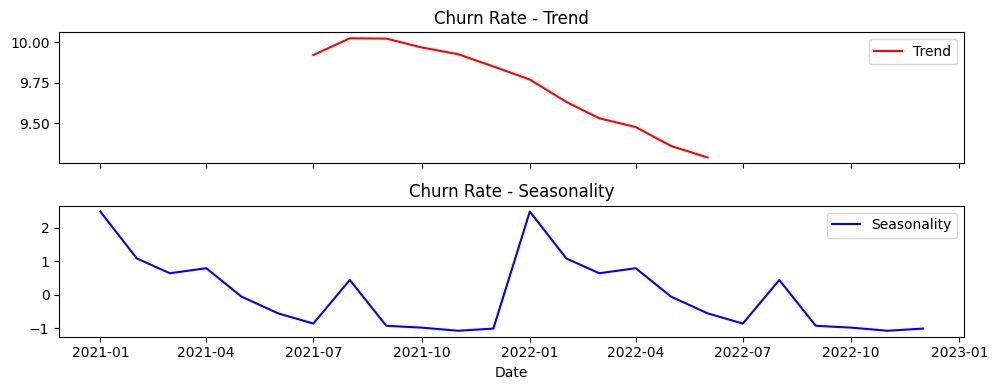

In [35]:
churn_df_overall_2.set_index("date", inplace=True)

# Perform seasonal decomposition (Multiplicative or Additive)
decomposition = seasonal_decompose(
    churn_df_overall_2["churn_rate"], model="additive", period=12
)

# Plot Trend and Seasonality
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# Trend Plot
axes[0].plot(decomposition.trend, label="Trend", color="red")
axes[0].set_title("Churn Rate - Trend")
axes[0].legend()

# Seasonality Plot
axes[1].plot(decomposition.seasonal, label="Seasonality", color="blue")
axes[1].set_title("Churn Rate - Seasonality")
axes[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Observações gerais:

* A média geral de churn é de 9,52%;
* Entre os anos de 2021 e 2022, houve uma redução da taxa churn $\rightarrow$ Tendência de redução das taxas de churn
* Sazonalidade de  churn:
  * Maiores taxas e churn no primeiro trimestre;
  * Existe um segundo pico entre os meses de agosto e setembr.

* **Necessário identificar os sinais que levam cliente a churn**
  * Redução seguinda em sales_volume
  * Queda ascentuada

### Taxa de churn - Por tier

In [40]:
def compute_churn_rate_tier(df):
    churn_stats = (
        df.groupby(["date", "tier", "ativo"])["client"]
        .nunique()  # Count unique clients per date per tier per ativo status
        .reset_index()
        .pivot(index=["date", "tier"], columns="ativo", values="client")
    )

    # Rename columns for clarity
    churn_stats.columns = ["inativo_t", "ativo_t"]  # 1 -> ativo_t, 0 -> inativo_t

    # Step 2: Compute Previous Active Clients (shift ativo_t per tier)
    churn_stats["prev_ativo"] = churn_stats.groupby("tier")["ativo_t"].shift(1)

    # Step 3: Compute Churn Rate (Avoid division by zero)
    churn_stats["churn_rate"] = (
        churn_stats["inativo_t"] / churn_stats["prev_ativo"]
    ) * 100

    # Step 4: Drop columns churn_rate is NaN
    churn_stats.dropna(subset="churn_rate", inplace=True)

    return churn_stats.reset_index()


churn_df_tier = compute_churn_rate_tier(churn_df_2)
churn_df_tier

,date,tier,inativo_t,ativo_t,prev_ativo,churn_rate
0,2021-02-01,0-1.5,20.00,19.00,23.00,86.96
1,2021-02-01,1.50-500,287.00,728.00,825.00,34.79
2,2021-02-01,2K-4K,69.00,1350.00,1275.00,5.41
3,2021-02-01,4K-9K,43.00,1392.00,1334.00,3.22
4,2021-02-01,500-2K,158.00,1217.00,1231.00,12.84
...,...,...,...,...,...,...
156,2022-12-01,2K-4K,135.00,1555.00,1628.00,8.29
157,2022-12-01,4K-9K,95.00,1986.00,2049.00,4.64
158,2022-12-01,500-2K,191.00,1025.00,1124.00,16.99
159,2022-12-01,71K-2M,4.00,172.00,175.00,2.29


##### Gráfico Tendência Vs Volume - Por tier

In [43]:
def plot_churn_rate_per_tier(churn_df):
    fig = px.line(
        churn_df,
        x="date",
        y="churn_rate",
        color="tier",
        title="Churn Rate Per Segment Over Time",
        markers=True,
        line_shape="linear",
    )

    # Alterar layout plotly
    fig.update_traces(hoverinfo="x+y+name")
    fig.update_layout(
        hovermode="x unified",
        xaxis_title="Date",
        yaxis_title="Churn Rate (%)",
        legend_title="Segment",
        height=600,
        width=900,
    )

    fig.show()


# Gerar gráfico
plot_churn_rate_per_tier(churn_df_tier)

* Observação: 
  * Note que o efeito sazonal também ocorre entre os diferentes Tiers, principalmente no primeiro trimestre. 
  * jan-2022 $\rightarrow$ Pico de churn. Vinculado ao efeito da COVID Onicrom.

#### Estatísticas consolidadas: Por tier

In [44]:
stats_tier_2 = (
    churn_df_tier.groupby(["tier"], as_index=True, sort=True)
    .agg(
        {
            "churn_rate": ["first", "last", "mean"],
        }
    )
    .round(2)
)

stats_tier_2.columns = stats_tier_2.columns.droplevel(1)

stats_tier_2.columns = [
    "churn_rate_first",
    "churn_rate_last",
    "churn_rate_avg",
]

stats_tier_2

,churn_rate_first,churn_rate_last,churn_rate_avg
tier,,,
0-1.5,86.96,81.82,93.28
1.50-500,34.79,37.53,38.25
2K-4K,5.41,8.29,7.84
4K-9K,3.22,4.64,4.99
500-2K,12.84,16.99,14.67
71K-2M,1.67,2.29,2.34
9K-71K,2.14,3.01,3.14


##### Gráfico Tendência Vs Volume

In [45]:
def plot_churn_analysis_tier(df, tier, line_feature, bar_feature):
    # Filter dataset by the selected tier
    churn_df = df[df["tier"] == tier].copy()

    # Ensure 'date' is in datetime format for proper plotting
    churn_df["date"] = pd.to_datetime(churn_df["date"])

    # Compute mean churn rate for the title
    churn_df_mean = churn_df[line_feature].mean().round(2)

    # Create subplots with 2 rows and shared x-axis
    fig = sp.make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        subplot_titles=(
            f"Churn Rate Over Time - Tier: {tier}",
            "Inactive Clients Over Time",
        ),
        vertical_spacing=0.2,
    )

    # Custom hover templates (separate for each chart)
    hover_template_line = "<b>Date:</b> %{x}<br>" "<b>Churn Rate:</b> %{y:.2f}%"

    hover_template_bar = "<b>Date:</b> %{x}<br>" "<b>Inactive Clients:</b> %{y}"

    # Top chart: Churn Rate (Line plot)
    fig.add_trace(
        go.Scatter(
            x=churn_df["date"],
            y=churn_df[line_feature],
            mode="lines+markers",
            name="Churn Rate",
            line=dict(color="red"),
            hovertemplate=hover_template_line,  # Corrected hover template for line plot
        ),
        row=1,
        col=1,
    )

    # Bottom chart: Inactive Clients (Bar plot)
    fig.add_trace(
        go.Bar(
            x=churn_df["date"],
            y=churn_df[bar_feature],
            name="Inactive Clients",
            marker_color="blue",
            hovertemplate=hover_template_bar,  # Corrected hover template for bar plot
        ),
        row=2,
        col=1,
    )

    # Update layout for better visualization
    fig.update_layout(
        height=600,
        width=900,
        hovermode="x unified",  # Enables synchronized hover
        legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1.04),
        title_text=f"Churn Analysis - Tier: {tier} (Avg Churn: {churn_df_mean}%)",
        xaxis_title="",
        yaxis_title="Churn Rate (%)",
        xaxis2_title="Date",
        yaxis2_title="Inactive Clients",
    )

    # Show figure
    fig.show()


# tier = "0-1.5 "

tier = "2K-4K"

plot_churn_analysis_tier(churn_df_tier, "2K-4K", "churn_rate", "inativo_t")

* Note que a taxa de churn varia bastante entre os diversos tiers, o que pode levar a uma interpetação equivocada da taxa de churn geral;
* Necessário ponderar as taxas peo clients_share de cada grupo no período analisado

### Taxa de churn geral ponderada por market share

#### Passo 1: Computar total de clientes por dia e tier

In [ ]:
stats_tier_date = (
    churn_df_2.groupby(["date", "tier"], as_index=True, sort=True)
    .agg(
        {
            "client": ["nunique"],
        }
    )
    .round(2)
)

stats_tier_date.columns = stats_tier_date.columns.droplevel(1)

stats_tier_date.columns = [
    "#_clients_tier_date",
]

stats_tier_date.reset_index(inplace=True)

stats_tier_date

stats_date = (
    churn_df_2.groupby(["date"], as_index=True, sort=True)
    .agg(
        {
            "client": ["nunique"],
        }
    )
    .round(2)
)

stats_date.columns = stats_date.columns.droplevel(1)

stats_date.columns = [
    "#_clients_all_date",
]

stats_date.reset_index(inplace=True)

#### Passo 2: Calcular market share por tier

In [49]:
stats_tier_full = stats_tier_date.merge(stats_date, on="date", how="inner")
stats_tier_full["share_tier_date"] = (
    stats_tier_full["#_clients_tier_date"] / stats_tier_full["#_clients_all_date"] * 100
)
stats_tier_full

,date,tier,#_clients_tier_date,#_clients_all_date,share_tier_date
0,2021-01-01,0-1.5,23,6150,0.37
1,2021-01-01,1.50-500,825,6150,13.41
2,2021-01-01,2K-4K,1275,6150,20.73
3,2021-01-01,4K-9K,1334,6150,21.69
4,2021-01-01,500-2K,1231,6150,20.02
...,...,...,...,...,...
163,2022-12-01,2K-4K,1690,8484,19.92
164,2022-12-01,4K-9K,2081,8484,24.53
165,2022-12-01,500-2K,1216,8484,14.33
166,2022-12-01,71K-2M,176,8484,2.07


In [50]:
churn_df_w = churn_df_tier.merge(stats_tier_full, on=["date", "tier"], how="left")

churn_df_w.head(7)

,date,tier,inativo_t,ativo_t,prev_ativo,churn_rate,#_clients_tier_date,#_clients_all_date,share_tier_date
0,2021-02-01,0-1.5,20.00,19.00,23.00,86.96,39,6861,0.57
1,2021-02-01,1.50-500,287.00,728.00,825.00,34.79,1015,6861,14.79
2,2021-02-01,2K-4K,69.00,1350.00,1275.00,5.41,1419,6861,20.68
3,2021-02-01,4K-9K,43.00,1392.00,1334.00,3.22,1435,6861,20.92
4,2021-02-01,500-2K,158.00,1217.00,1231.00,12.84,1375,6861,20.04
5,2021-02-01,71K-2M,1.00,68.00,60.00,1.67,69,6861,1.01
6,2021-02-01,9K-71K,30.00,1479.00,1402.00,2.14,1509,6861,21.99


#### Passo 3: Calcular taxa geral de churn ponderada por market share

In [51]:
weighted_churn_rate_df = (
    churn_df_w.groupby("date")
    .apply(
        lambda x: ((x["churn_rate"] / 100) * (x["share_tier_date"] / 100)).sum() * 100
    )  # Convert back to percentage
    .reset_index(name="churn_rate_weighted")
)

##### Gráfico Taxa Churn - Visão geral Ponderada 

In [54]:
def plot_churn_comparison(original_df, weighted_df):
    fig = go.Figure()

    # Add Original Churn Rate (Line)
    fig.add_trace(
        go.Scatter(
            x=original_df["date"],
            y=original_df["churn_rate"],
            mode="lines+markers",
            name="Original Churn Rate",
            line=dict(color="red"),
        )
    )

    # Add Weighted Churn Rate (Line)
    fig.add_trace(
        go.Scatter(
            x=weighted_df["date"],
            y=weighted_df["churn_rate_weighted"],
            mode="lines+markers",
            name="Weighted Churn Rate",
            line=dict(color="blue"),
        )
    )

    # Update Layout
    fig.update_layout(
        title="Comparison of Original vs Weighted Churn Rate",
        xaxis_title="Date",
        yaxis_title="Churn Rate (%)",
        legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1),
        hovermode="x unified",  # Enables a single hover across both lines
        width=900,
        height=500,
    )

    # Show Plot
    fig.show()


# Call the function
plot_churn_comparison(churn_df_overall, weighted_churn_rate_df)

* Insights para as lideranças da companhia:
  
  * Sazonalidade do churn:
    * **As maiores taxas de churn ocorrem no primeiro trimestre**;
    * Eventos extremos (como a COVID) tendem a provocar efeitos significativos nas taxas de churn.
* Clientes mais afetados: Tiers 1.50 - 500 e 500 - 2k $\rightarrow$ Correspondem a cerca de 40% dos clientes da instituição.
* Clientes com alto valor de receita são menos influenciados por eventos econômicos.
* **Clientes de menor valor são os mais frágeis e apresentam maior probabilidade de churn**.